In [48]:
import os
import numpy as np
import pandas as pd

import torch
from torchvision.datasets import MNIST
from captum.attr import GradientShap

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from lfxai.explanations.features import attribute_auxiliary
from lfxai.models.images import ClassifierMnist, EncoderMnist
import copy

from matplotlib import pyplot as plt

In [3]:
# Basic setup
torch.random.manual_seed(123)
batch_size = 128
device = 'cpu'

# Model Args
image_height = 28
dim_latent = 4

In [4]:
# Data loading
data_dir = "data/mnist"
shared_transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MNIST(data_dir, train=True, download=True, transform=shared_transform
                                           )
test_dataset = MNIST(data_dir, train=False, download=True, transform=shared_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [5]:
#### Model loading ######
# Specification
dim_latent = 4
name = "TestClassifier"
classifier_state_dict_path = os.path.join('..', 'TrainedModels', 'MNIST', 'Classifier_run0.pt') # TODO Need to loop over runs

# Load
encoder = EncoderMnist(dim_latent)

classifier = ClassifierMnist(encoder, dim_latent, name)
classifier.load_state_dict(torch.load(classifier_state_dict_path), strict=True)

encoder = copy.deepcopy(classifier.encoder) # Necessary? Should check whether the load just modifies the original

print("Classifier Loaded")

Classifier Loaded


In [9]:
# Instantiate GradShap For Encoder and Full Model
gradshap_encoder = GradientShap(encoder)
gradshap_full_model = GradientShap(classifier)


In [10]:
baseline_image = torch.zeros((1, 1, 28, 28), device=device)

In [11]:
encoder_attributions = attribute_auxiliary(
                        encoder, test_loader, device, gradshap_encoder, baseline_image
                    )

# Note that this is the correct thing to do here because the classifier outputs probabilities so we are taking a soft sum
pipeline_attributions = attribute_auxiliary(
    classifier, test_loader, device, gradshap_full_model, baseline_image
)



In [12]:
pd.Series(encoder_attributions.mean(axis=0).flatten()).describe()

count    784.000000
mean       0.003056
std        1.086552
min       -6.064140
25%       -0.085170
50%        0.000000
75%        0.110991
max        5.611664
dtype: float64

In [13]:
pd.Series(pipeline_attributions.mean(axis=0).flatten()).describe()

count    784.000000
mean      -0.000001
std        0.000197
min       -0.001203
25%       -0.000021
50%        0.000000
75%        0.000033
max        0.000836
dtype: float64

In [17]:
# Cast each one to absolute value, since we're not interested in the direction on the hidden space
encoder_attributions = np.abs(encoder_attributions)
pipeline_attributions = np.abs(pipeline_attributions)

# Normalise each one to have variance 1
encoder_attributions = encoder_attributions/np.std(encoder_attributions)
pipeline_attributions = pipeline_attributions/np.std(pipeline_attributions)


Text(0.5, 1.0, 'Classifier Saliency Map')

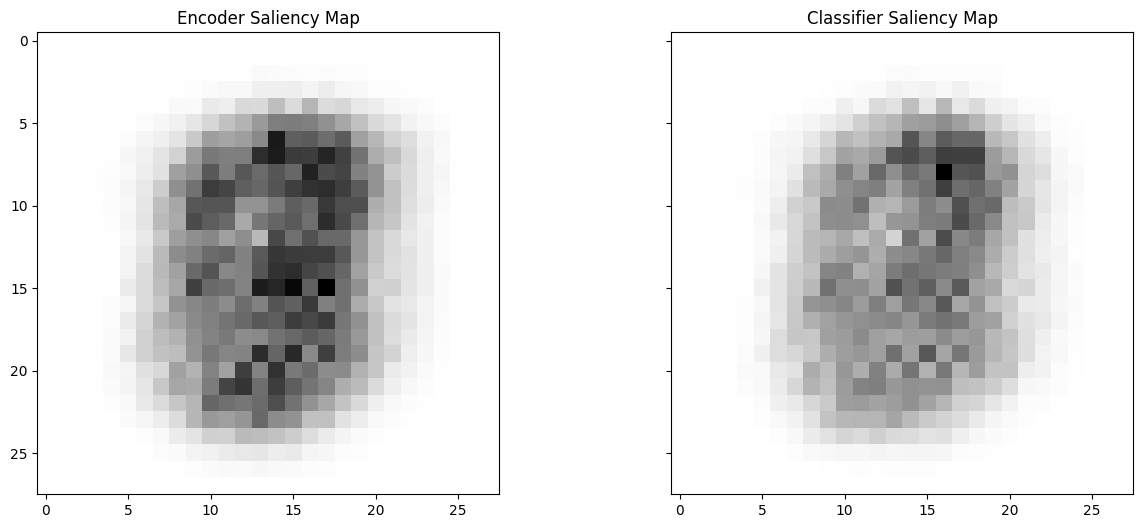

In [29]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=[15, 6])
ax[0].imshow(encoder_attributions.mean(axis=0).squeeze(), cmap='gray_r')
ax[0].set_title('Encoder Saliency Map')

ax[1].imshow(pipeline_attributions.mean(axis=0).squeeze(), cmap='gray_r')
ax[1].set_title('Classifier Saliency Map')

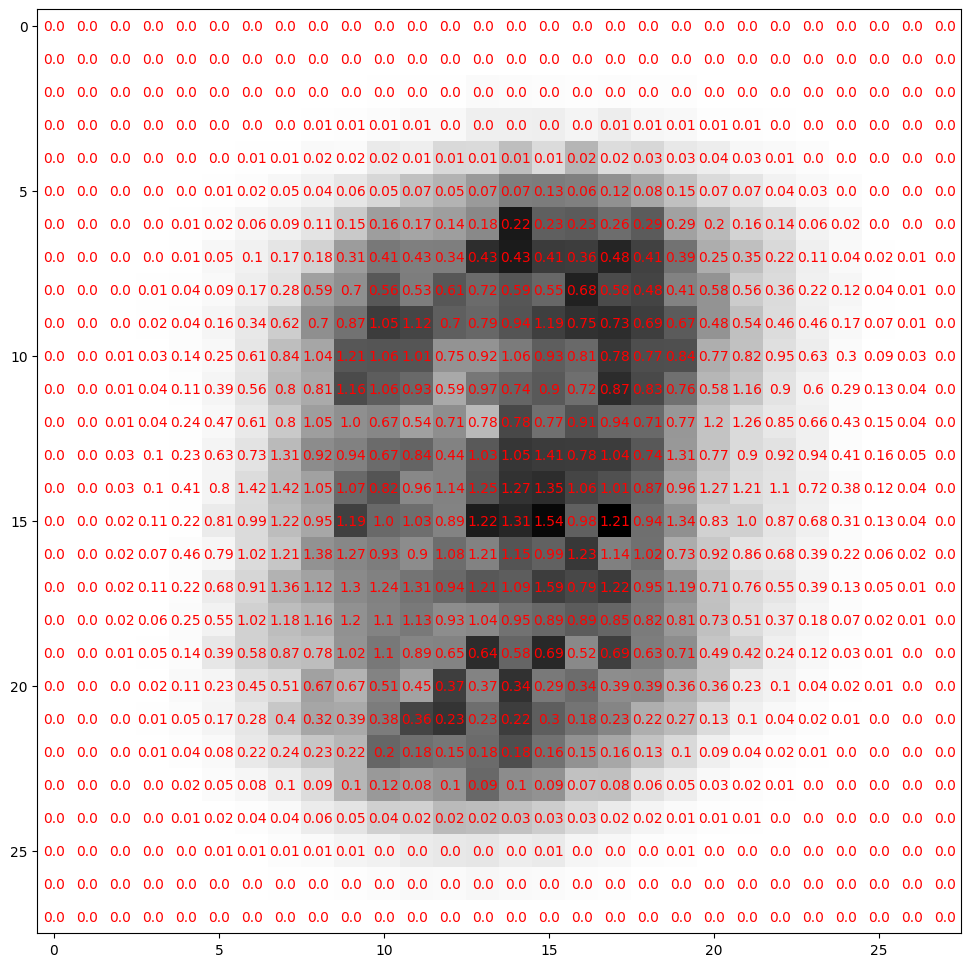

In [32]:
# As above, but shows more detail so that we can understand what's going on better
fig, ax = plt.subplots(figsize=[12, 12])
ax.imshow(encoder_attributions.mean(axis=0).squeeze(), cmap='gray_r')
for (i, j), pixel_value in np.ndenumerate(np.mean(encoder_attributions, axis=0).squeeze().round(2)):
    ax.text(i, j, pixel_value, c='red', ha='center',va='center')

In [37]:
# Compute the pearson correlation between the maps
# TODO we should also exclude constant/nearly constant pixels?

# Note there are a few ways we could possibly do this, e.g. taking the mean of the feature values first
# However, I think that unnecessarily discards structure that we might otherwise want to keep.
pearsons_rho = np.corrcoef(encoder_attributions.flatten(), pipeline_attributions.flatten())
pearsons_rho

array([[1.        , 0.23498141],
       [0.23498141, 1.        ]])

In [35]:
# Alternatively, we may want to consider the R**2 value. Assuming a linear relationship + intercept, this is just the
# Square of the pearson coefficient.
pearsons_rho**2

array([[1.        , 0.05521626],
       [0.05521626, 1.        ]])

In [38]:
# Finally we can look at what happens when we first aggregate across the images
pearsons_rho_agg = np.corrcoef(encoder_attributions.mean(axis=0).flatten(), pipeline_attributions.mean(axis=0).flatten())
pearsons_rho_agg

array([[1.        , 0.98415337],
       [0.98415337, 1.        ]])

(array([415.,  69.,  53.,  45.,  37.,  21.,  14.,   9.,   4.,   1.]),
 array([3.23103905e-11, 2.26761431e-01, 4.53522861e-01, 6.80284321e-01,
        9.07045722e-01, 1.13380718e+00, 1.36056864e+00, 1.58733010e+00,
        1.81409144e+00, 2.04085302e+00, 2.26761436e+00]),
 <BarContainer object of 10 artists>)

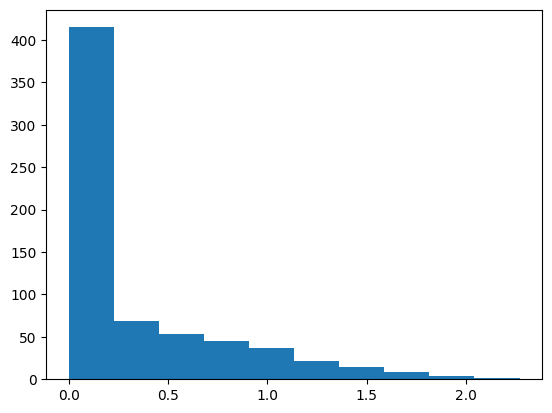

In [33]:
dots = (encoder_attributions*pipeline_attributions).mean(axis=0).squeeze()
dots = dots[np.abs(dots) > 0]

plt.hist(dots.flatten())

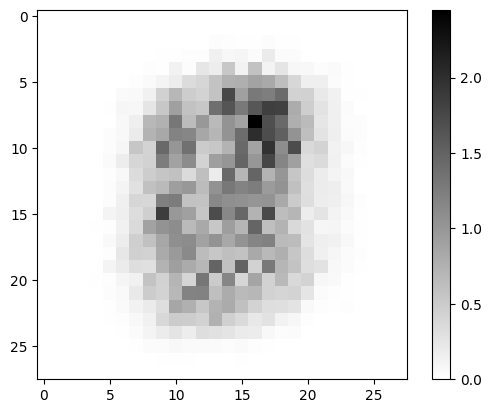

In [216]:
plt.imshow((encoder_attributions*pipeline_attributions).mean(axis=0).squeeze(), cmap='gray_r')
plt.colorbar()

We have something of a puzzle - why do the correlations skyrocket when we first aggregate across the dimensions?

To solve this, let's examine what happens in the case of a _single_ image.

In [52]:
i = 0

a_enc_i = encoder_attributions[i].squeeze()
a_full_i = pipeline_attributions[i].squeeze()

fig, ax = plt.subplots(1, 2, sharey='yes', figsize=[15, 6])
ax[0].imshow(a_enc_i.mean(axis=0).squeeze(), cmap='gray_r')
ax[0].set_title('Encoder Saliency Map')

ax[1].imshow(pipeline_attributions.mean(axis=0).squeeze(), cmap='gray_r')
ax[1].set_title('Classifier Saliency Map')

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.000000

#### Excluding constant pixels - NOTE probably not needed

We want to exclude pixels that are always (or almost always) black, since these will trivially be highly correlated between all methods. In the following, we mask out pixels that never have a positive feature importance value.

In [103]:
# Cod to mask out constant pixels with nan
# TODO convert this to a function

# Concatenate all the data
cats = [X for X, y in test_loader]
y = [y for X, y in test_loader]
cats = np.concatenate(cats)

mask = cats.max(axis=0) == cats.min(axis=0) # Identify all constant pixels
mask = mask[np.newaxis, ...] # Create a new axis to tile back across
mask = np.repeat(mask, cats.shape[0], axis=0) # Fill out dimensions of the new axis
cats[mask] = np.nan # Mask out constant pixels

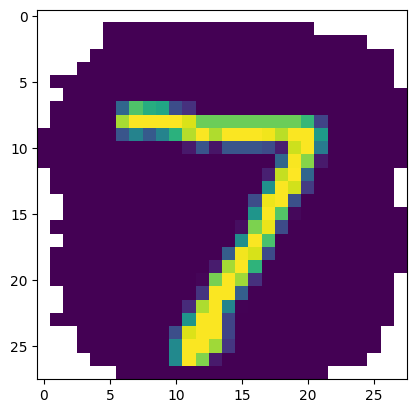

In [104]:
plt.imshow(cats[0, 0])

In [108]:
class MaskedData(Dataset):
    # TODO this feels insane - maybe someone knows an easier way
    def __init__(self, masked_data, labels, transform):
        self._data = masked_data
        self._labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        X = self._data[idx]
        X = self.transform(X)
        y = self._labels[idx]
        return X, y

In [110]:
# Now we have to load it back into a dataloader to recyle the old functions
masked_data = MaskedData(cats, y, transform=shared_transform)
masked_loader = DataLoader(masked_data, batch_size=batch_size)